In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression

# Data description

This data set includes hourly air pollutants from a monitoring site in the city of Beijing from March 1st, 2013 to February 28th, 2017. The air-quality data are from the Beijing Municipal Environmental Monitoring Center. The meteorological data in each air-quality site are matched with the nearest weather station from the China Meteorological Administration.

- No: row number   
- year: year of data in this row   
- month: month of data in this row   
- day: day of data in this row  
- hour: hour of data in this row   
- PM2.5: PM2.5 concentration (ug/m^3)  
- PM10: PM10 concentration (ug/m^3)  
- SO2: SO2 concentration (ug/m^3)  
- NO2: NO2 concentration (ug/m^3)  
- CO: CO concentration (ug/m^3)  
- O3: O3 concentration (ug/m^3)  
- TEMP: temperature (degree Celsius)   
- PRES: pressure (hPa)  
- DEWP: dew point temperature (degree Celsius)  
- RAIN: precipitation (mm)  
- wd: wind direction  
- WSPM: wind speed (m/s)  
- station: name of the air-quality monitoring site  


In [5]:
df = pd.read_csv('AQ_data.csv', delimiter=',')
df.columns = df.columns.str.lower().str.replace('.', '_')

df.head()


,no,year,month,day,hour,pm2_5,pm10,so2,no2,co,o3,temp,pres,dewp,rain,wd,wspm,station
0,1,2013,3,1,0,9.0,9.0,6.0,17.0,200.0,62.0,0.3,1021.9,-19.0,0.0,WNW,2.0,Wanshouxigong
1,2,2013,3,1,1,11.0,11.0,7.0,14.0,200.0,66.0,-0.1,1022.4,-19.3,0.0,WNW,4.4,Wanshouxigong
2,3,2013,3,1,2,8.0,8.0,NaN,16.0,200.0,59.0,-0.6,1022.6,-19.7,0.0,WNW,4.7,Wanshouxigong
3,4,2013,3,1,3,8.0,8.0,3.0,16.0,NaN,NaN,-0.7,1023.5,-20.9,0.0,NW,2.6,Wanshouxigong
4,5,2013,3,1,4,8.0,8.0,3.0,NaN,300.0,36.0,-0.9,1024.1,-21.7,0.0,WNW,2.5,Wanshouxigong


# Exploratory Data Analysis and Feature Engineering

### Checking data type

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   no       35064 non-null  int64  
 1   year     35064 non-null  int64  
 2   month    35064 non-null  int64  
 3   day      35064 non-null  int64  
 4   hour     35064 non-null  int64  
 5   pm2_5    34368 non-null  float64
 6   pm10     34580 non-null  float64
 7   so2      34395 non-null  float64
 8   no2      34310 non-null  float64
 9   co       33767 non-null  float64
 10  o3       33986 non-null  float64
 11  temp     35045 non-null  float64
 12  pres     35045 non-null  float64
 13  dewp     35045 non-null  float64
 14  rain     35045 non-null  float64
 15  wd       34985 non-null  object 
 16  wspm     35051 non-null  float64
 17  station  35064 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 4.8+ MB


### Missing values

In [7]:
df.isnull().sum()

no            0
year          0
month         0
day           0
hour          0
pm2_5       696
pm10        484
so2         669
no2         754
co         1297
o3         1078
temp         19
pres         19
dewp         19
rain         19
wd           79
wspm         13
station       0
dtype: int64

In [8]:
missing_values = df[['temp', 'pres', 'dewp', 'rain']].isnull().sum()
missing_values

temp    19
pres    19
dewp    19
rain    19
dtype: int64

We have multiple columns with missing values. Let's consider weather parameters first, like:  "temperature", "pressure", "dew point temperature", "rain" and "windspeed".

In [9]:
data = {
    'min': [df['temp'].min(), df['pres'].min(),df['dewp'].min(),df['rain'].min(), df['wspm'].min()],
    'max': [df['temp'].max(), df['pres'].max(),df['dewp'].max(),df['rain'].max(), df['wspm'].max()], 
    'average':[df['temp'].mean(), df['pres'].mean(),df['dewp'].mean(),df['rain'].mean(), df['wspm'].mean()]
}
df_weather = pd.DataFrame(data, index=['Temperature', 'Pressure', 'Dew Point Temp', 'Rain', 'Wind Speed'])
df_weather

,min,max,average
Temperature,-16.8,40.6,13.784477
Pressure,985.1,1042.0,1011.511804
Dew Point Temp,-35.3,28.5,2.707442
Rain,0.0,46.4,0.064320
Wind Speed,0.0,13.2,1.745314


The variation in the data is too important to justify replacing missing values with the average. Doing so could introduce bias, as the values are collected hourly and exhibit temporal correlations. Instead, we will replace each missing value by the average over the previous and next value.

In [10]:
for col in ['temp', 'pres', 'dewp', 'rain', 'wspm']:
   
    df[col + '_ffill'] = df[col].ffill()
    df[col + '_bfill'] = df[col].bfill()
    df[col] = df.apply(
        lambda row: (row[col + '_ffill'] + row[col + '_bfill']) / 2 if pd.isnull(row[col]) else row[col],
        axis=1
    )
    
    df.drop([col + '_ffill', col + '_bfill'], axis=1, inplace=True)
df[['temp', 'pres', 'dewp', 'rain']].isnull().sum()

temp    0
pres    0
dewp    0
rain    0
dtype: int64

Let us now consider the missing values in the polluants concentration : 'pm2_5', 'pm10', 'so2', 'no2', 'co', 'o3'.

In [11]:
data = {
    'min': [df['pm2_5'].min(), df['pm10'].min(),df['so2'].min(),df['no2'].min(), df['co'].min(),df['o3'].min()],
    'max': [df['pm2_5'].max(), df['pm10'].max(),df['so2'].max(),df['no2'].max(), df['co'].max(),df['o3'].max()], 
    'average':[df['pm2_5'].mean(), df['pm10'].mean(),df['so2'].mean(),df['no2'].mean(), df['co'].mean(),df['o3'].mean()]
}
df_weather = pd.DataFrame(data, index=['Pm2.5', 'Pm10', 'So2', 'No2', 'Co', 'O3'])
df_weather

,min,max,average
Pm2.5,3.0000,999.0,85.024136
Pm10,2.0000,961.0,112.223459
So2,0.2856,411.0,17.148603
No2,2.0000,251.0,55.529560
Co,100.0000,9800.0,1370.395031
O3,0.2142,358.0,56.229904


For the same reason as previously, we will replace each missing value by the average over the previous and next value.

In [12]:
for col in ['pm2_5', 'pm10', 'so2', 'no2', 'co', 'o3']:
   
    df[col + '_ffill'] = df[col].ffill()
    df[col + '_bfill'] = df[col].bfill()
    df[col] = df.apply(
        lambda row: (row[col + '_ffill'] + row[col + '_bfill']) / 2 if pd.isnull(row[col]) else row[col],
        axis=1
    )
    
    df.drop([col + '_ffill', col + '_bfill'], axis=1, inplace=True)
df[['pm2_5', 'pm10', 'so2', 'no2', 'co', 'o3']].isnull().sum()

pm2_5    0
pm10     0
so2      0
no2      0
co       0
o3       0
dtype: int64

The "79" missig values from the wind direction column will be replaced by the next value.

In [13]:
df['wd'] = df['wd'].bfill()
df.isnull().sum()

no         0
year       0
month      0
day        0
hour       0
pm2_5      0
pm10       0
so2        0
no2        0
co         0
o3         0
temp       0
pres       0
dewp       0
rain       0
wd         0
wspm       0
station    0
dtype: int64

In [14]:
df['wd'].value_counts()

wd
NE     3603
SW     3433
ENE    3085
E      2811
WNW    2569
NW     2565
WSW    2546
W      2468
SSW    2457
ESE    1773
NNE    1566
S      1508
SE     1282
NNW    1187
N      1177
SSE    1034
Name: count, dtype: int64

There are 16 wind directions possible. We map the direction to the angle.

In [15]:
direction_to_angle = {
    'N': 0,
    'NNE': 22.5,
    'NE': 45,
    'ENE': 67.5,
    'E': 90,
    'ESE': 112.5,
    'SE': 135,
    'SSE': 157.5,
    'S': 180,
    'SSW': 202.5,
    'SW': 225,
    'WSW': 247.5,
    'W': 270,
    'WNW': 292.5,
    'NW': 315,
    'NNW': 337.5
}
df['wa'] = df['wd'].map(direction_to_angle)
df['wd'] = df['wa']
del df['wa']

### Correlation matrix
We want to calculate the correlation coefficient between parameters to see the ones we can drop to reduce the number of parameters.
We delete the "no" and "station" column.

In [16]:
del df['station']
del df['no']

correlation_matrix = df.corr()

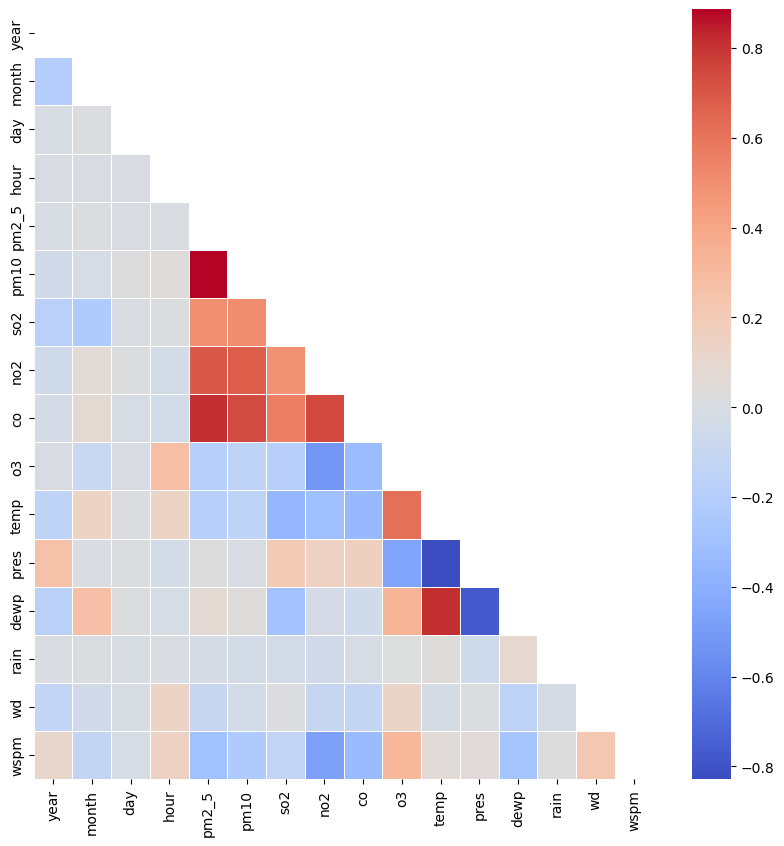

In [17]:
plt.figure(figsize=(10, 10))  # Increase the size if necessary
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5, mask=mask)
plt.show()

- We observe a high  correlation between PM2.5 and PM10 of over 0.8 (both represent particulate matter but of different sizes 2.5 and 10 microns respectively. 
- Temperature and dew point show a strong correlation. Temperature and dew point are closely linked. We can remove dew point. The dew point temperature is the temperature at which the air reaches 100% relative humidity.
- Wind speed and directions show some correlations for specific wind directions.
- Pressure shows a strong negative correlation with temperature as expected. Both are good predictors of athmospheric conditions.


In [18]:
del df['dewp']

### AQI Calculation
Now that we have filled missing values, using polluants concentration we' want to determine what is the overall AQI (Air Quality Index). The AQI is a scale that provides real-time information on the amount of pollution in the air.  
There are 6 scales : 
- 0 - 50 : Good
- 51 - 100 : Moderate
- 101 - 500 : Unhealthy for Sensitive Groups
- 151 - 200 : Unhealthy
- 201 - 300 : Very Unhealthy
- 300 + : Hazardous

In order to calculate the overall AQI, we have to calculate the individual AQI for each polluant. The overall AQI is obtained by taking the maximum value among the five polluants : Pm2.5 , So2, No2, Co and O3.  
The AQI for each polluant is calculated using the standard that gives the AQI level according to the polluant concentration.


These standards are for a concentration on a 24-hour average for Pm2.5, So2, No2 and 8-hour average for Co and O3

In [19]:
df['pm25_avg'] = df['pm2_5'].rolling(window=24, min_periods=24).mean().round(2)
df['pm10_avg'] = df['pm10'].rolling(window=24, min_periods=24).mean().round(2)
df['so2_avg'] = df['so2'].rolling(window=24, min_periods=24).mean().round(2)
df['no2_avg'] = df['no2'].rolling(window=24, min_periods=24).mean().round(2)
df['co_avg'] = df['co'].rolling(window=8, min_periods=8).mean().round(2)
df['o3_avg'] = df['o3'].rolling(window=8, min_periods=8).mean().round(2)
df.dropna(subset=['pm25_avg', 'so2_avg','no2_avg','co_avg','o3_avg'  ], inplace=True)
df

,year,month,day,hour,pm2_5,pm10,so2,no2,co,o3,...,pres,rain,wd,wspm,pm25_avg,pm10_avg,so2_avg,no2_avg,co_avg,o3_avg
23,2013,3,1,23,15.0,15.0,14.0,41.0,500.0,31.0,...,1029.6,0.0,67.5,1.8,8.04,10.75,7.33,18.00,437.50,50.38
24,2013,3,2,0,5.0,10.0,11.0,35.0,400.0,39.0,...,1030.2,0.0,67.5,1.4,7.88,10.79,7.54,18.75,450.00,46.25
25,2013,3,2,1,3.0,8.0,9.0,33.0,400.0,40.0,...,1030.2,0.0,90.0,1.0,7.54,10.67,7.62,19.54,462.50,42.88
26,2013,3,2,2,3.0,6.0,9.0,29.0,300.0,44.0,...,1029.6,0.0,90.0,0.8,7.33,10.58,7.79,20.08,450.00,41.12
27,2013,3,2,3,3.0,6.0,9.0,29.0,400.0,43.0,...,1029.7,0.0,0.0,0.1,7.12,10.50,8.04,20.62,437.50,40.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,...,1013.5,0.0,315.0,2.4,17.58,31.08,5.96,42.15,281.25,80.38
35060,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,...,1013.6,0.0,292.5,0.9,16.12,29.04,5.79,39.44,306.25,77.00
35061,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,...,1014.2,0.0,315.0,1.1,14.33,26.83,5.58,36.31,331.25,73.50
35062,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,...,1014.4,0.0,337.5,1.2,12.58,23.54,5.21,32.69,350.00,70.62


In [20]:
def calculate_aqi_pm25(conc):
    if conc <= 12:
        return (50/12) * conc
    elif conc <= 35.4:
        return ((conc - 12.1) / (35.4 - 12.1)) * (100 - 51) + 51
    elif conc <= 55.4:
        return ((conc - 35.5) / (55.4 - 35.5)) * (150 - 101) + 101
    elif conc <= 150.4:
        return ((conc - 55.5) / (125.4 - 55.5)) * (200 - 151) + 151
    elif conc <= 250.4:
        return ((conc - 150.5) / (250.4 - 150.5)) * (300 - 201) + 201
    elif conc > 500.4 :
        return ((conc - 250.5) / (500.4 - 250.5)) * (500 - 401) + 401
    else :
        return 501

In [21]:
def calculate_aqi_pm10(conc):
    if conc <= 50:
        return conc
    elif conc <= 100:
        return conc
    elif conc <= 250:
        return 100 + (conc - 100) * 100 / 150
    elif conc <= 350:
        return 200 + (conc - 250)
    elif conc <= 430:
        return 300 + (conc - 350) * 100 / 80
    elif conc > 430:
        return 400 + (conc - 430) * 100 / 80
    else:
        return 0

In [22]:
def calculate_aqi_so2(conc):
    if conc <= 40:
        return conc * 50 / 40
    elif conc <= 80:
        return 51 + (conc - 40) * 50 / 40
    elif conc <= 380:
        return 101 + (conc - 80) * 100 / 300
    elif conc <= 800:
        return 201 + (conc - 380) * 100 / 420
    elif conc <= 1600:
        return 301 + (conc - 800) * 100 / 800
    elif conc > 1600:
        return 401 + (conc - 1600) * 100 / 800
    else:
        return 501

In [23]:
def calculate_aqi_no2(conc):
    if conc <= 53*1.88:
        return (conc / 53*1.88) * 50  
    elif conc <= 100*1.88:
        return ((conc - 54*1.88) / (100*1.88 - 54*1.88)) * (100-51) + 51  
    elif conc <= 360*1.88:
        return ((conc - 101*1.88) / (360*1.88 - 101*1.88)) * (150-101) + 101  
    elif conc <= 649*1.88:
        return ((conc - 361*1.88) / (649*1.88 - 361*1.88)) * (200-151) + 151 
    elif conc <= 1249*1.88:
        return ((conc - 650*1.88) / (1249*1.88 - 650*1.88)) * (300-201) + 201 
    elif conc > 2049*1.88:
      return ((conc - 1250*1.88) / (2049*1.88 - 1250*1.88)) * (500-301) + 301 
    else:
        return 501


In [24]:
def calculate_aqi_co(conc):
    if conc <= 5041:
        return (50 / 5041) * conc
    elif conc <= 10769:
        return ((conc - 5155) / (10769 - 5155)) * (100 - 51) + 51

In [25]:
def calculate_aqi_o3(conc):
    if conc <= 50:
        return conc * 50 / 50
    elif conc <= 100:
        return 51 + (conc - 50) * 50 / 50
    elif conc <= 168:
        return 101 + (conc - 100) * 100 / 68
    elif conc <= 208:
        return 201 + (conc - 168) * 100 / 40
    elif conc <= 748:
        return 301 + (conc - 208) * 100 / 539
    elif conc > 748:
        return 401 + (conc - 400) * 100 / 539
    else:
        return 501


In [26]:
df['pm25_aqi'] = round(df['pm25_avg'].apply(calculate_aqi_pm25),2)
df['pm10_aqi'] = round(df['pm10_avg'].apply(calculate_aqi_pm10),2)
df['so2_aqi'] = round(df['so2_avg'].apply(calculate_aqi_so2),2)
df['no2_aqi'] = round(df['no2_avg'].apply(calculate_aqi_no2),2)
df['co_aqi'] = round(df['co_avg'].apply(calculate_aqi_co),2)
df['o3_aqi'] = round(df['o3_avg'].apply(calculate_aqi_o3),2)

In [27]:
df

,year,month,day,hour,pm2_5,pm10,so2,no2,co,o3,...,so2_avg,no2_avg,co_avg,o3_avg,pm25_aqi,pm10_aqi,so2_aqi,no2_aqi,co_aqi,o3_aqi
23,2013,3,1,23,15.0,15.0,14.0,41.0,500.0,31.0,...,7.33,18.00,437.50,50.38,33.50,10.75,9.16,31.92,4.34,51.38
24,2013,3,2,0,5.0,10.0,11.0,35.0,400.0,39.0,...,7.54,18.75,450.00,46.25,32.83,10.79,9.43,33.25,4.46,46.25
25,2013,3,2,1,3.0,8.0,9.0,33.0,400.0,40.0,...,7.62,19.54,462.50,42.88,31.42,10.67,9.52,34.66,4.59,42.88
26,2013,3,2,2,3.0,6.0,9.0,29.0,300.0,44.0,...,7.79,20.08,450.00,41.12,30.54,10.58,9.74,35.61,4.46,41.12
27,2013,3,2,3,3.0,6.0,9.0,29.0,400.0,43.0,...,8.04,20.62,437.50,40.25,29.67,10.50,10.05,36.57,4.34,40.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,...,5.96,42.15,281.25,80.38,62.52,31.08,7.45,74.76,2.79,81.38
35060,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,...,5.79,39.44,306.25,77.00,59.45,29.04,7.24,69.95,3.04,78.00
35061,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,...,5.58,36.31,331.25,73.50,55.69,26.83,6.98,64.40,3.29,74.50
35062,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,...,5.21,32.69,350.00,70.62,52.01,23.54,6.51,57.98,3.47,71.62


To calculate the overall AQI from the AQI values of each individual pollutant (e.g., PM2.5, PM10, SO2, NO2, CO, O3), the overall AQI is typically determined by taking the maximum AQI value across all pollutants for a given time period. This is because the highest pollutant concentration (i.e., the highest AQI) dictates the overall air quality.

In [28]:
df['aqi'] = df[['pm25_aqi', 'pm10_aqi','so2_aqi', 'no2_aqi', 'co_aqi', 'o3_aqi']].max(axis=1)
#df['aqi'] = df[['pm2_5_aqi', 'so2_aqi', 'co_aqi', 'o3_aqi']].max(axis=1)

#df['aqi'] = df[['pm2_5_aqi', 'so2_aqi', 'no2_aqi', 'co_aqi']].max(axis=1)


Now that we calculated the overall AQI, we delete the AQI related to each polluant since the overall AQI is derived from individual AQIs.  

In [29]:
del df['pm25_aqi']
del df['pm10_aqi']
del df['so2_aqi']
del df['no2_aqi']
del df['co_aqi']
del df['o3_aqi']


In [30]:
df

,year,month,day,hour,pm2_5,pm10,so2,no2,co,o3,...,rain,wd,wspm,pm25_avg,pm10_avg,so2_avg,no2_avg,co_avg,o3_avg,aqi
23,2013,3,1,23,15.0,15.0,14.0,41.0,500.0,31.0,...,0.0,67.5,1.8,8.04,10.75,7.33,18.00,437.50,50.38,51.38
24,2013,3,2,0,5.0,10.0,11.0,35.0,400.0,39.0,...,0.0,67.5,1.4,7.88,10.79,7.54,18.75,450.00,46.25,46.25
25,2013,3,2,1,3.0,8.0,9.0,33.0,400.0,40.0,...,0.0,90.0,1.0,7.54,10.67,7.62,19.54,462.50,42.88,42.88
26,2013,3,2,2,3.0,6.0,9.0,29.0,300.0,44.0,...,0.0,90.0,0.8,7.33,10.58,7.79,20.08,450.00,41.12,41.12
27,2013,3,2,3,3.0,6.0,9.0,29.0,400.0,43.0,...,0.0,0.0,0.1,7.12,10.50,8.04,20.62,437.50,40.25,40.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,...,0.0,315.0,2.4,17.58,31.08,5.96,42.15,281.25,80.38,81.38
35060,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,...,0.0,292.5,0.9,16.12,29.04,5.79,39.44,306.25,77.00,78.00
35061,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,...,0.0,315.0,1.1,14.33,26.83,5.58,36.31,331.25,73.50,74.50
35062,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,...,0.0,337.5,1.2,12.58,23.54,5.21,32.69,350.00,70.62,71.62


### Monthly weather data variation 
We check the monthly variation of rain, temperature and wind speed to understand the weather of the city better.

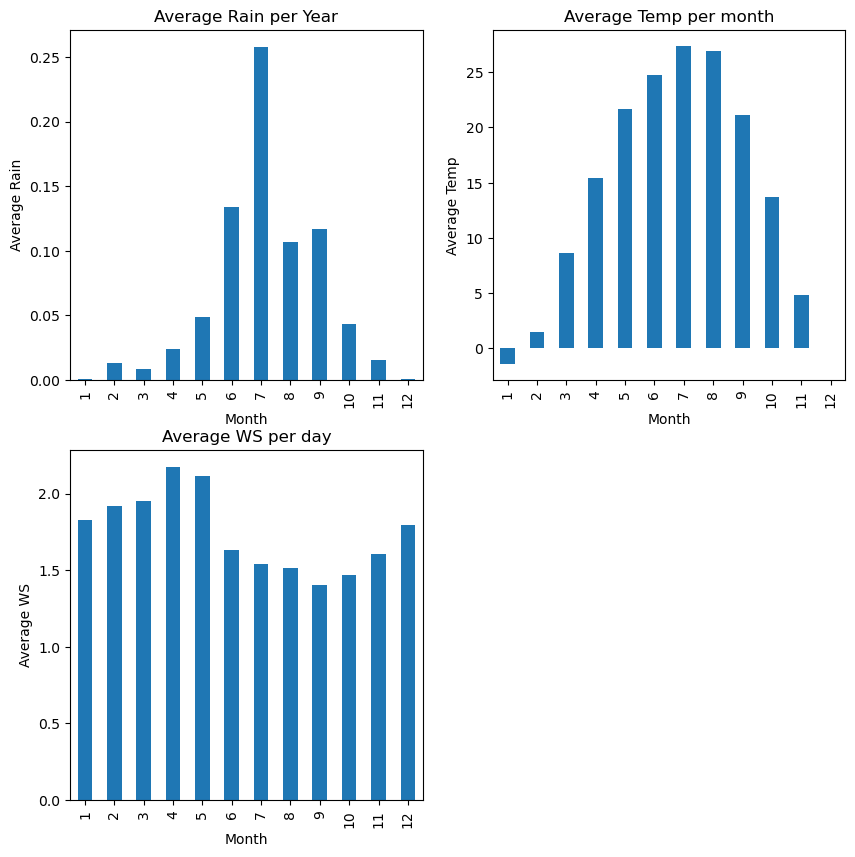

In [31]:
plt.figure(figsize=(10, 10))

rain_dt = df.groupby('month')['rain'].mean()
temp_dt = df.groupby('month')['temp'].mean()
wind_dt = df.groupby('month')['wspm'].mean()

plt.subplot(2,2,1)
rain_dt.plot(kind='bar', title='Average Rain per Year')
plt.xlabel('Month')
plt.ylabel('Average Rain')

plt.subplot(2,2,2)
temp_dt.plot(kind='bar', title='Average Temp per month')
plt.xlabel('Month')
plt.ylabel('Average Temp')

plt.subplot(2,2,3)
wind_dt.plot(kind='bar', title='Average WS per day')
plt.xlabel('Month')
plt.ylabel('Average WS')

plt.show()

## AQI Variation
We check the yearly, monthly, daily and hourly variation of AQI to identify any potential patterns.
From the histograms, we see that the AQI : 
- Remained relatively consistent across the years, though a slight increase noted in AQI in 2017.
- Is higher during the fall-winter months.
- Some variations are observfed throughout the month.
- Is pretty stable throughout the night-morning then increases during the afternoon to approximately 15%


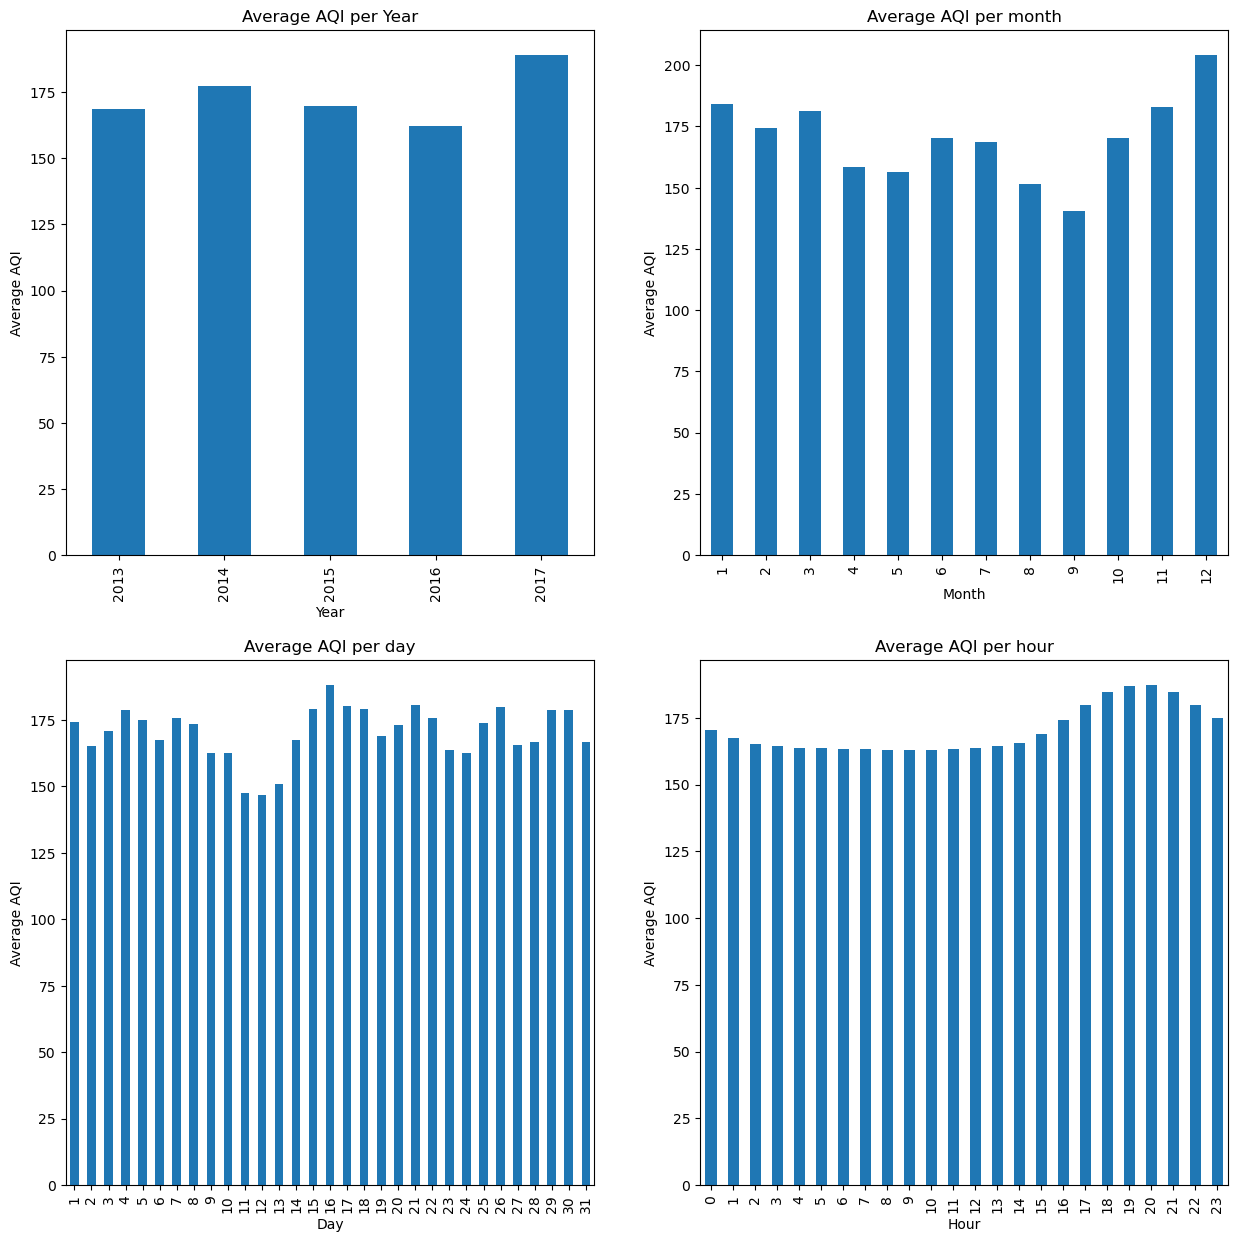

In [32]:
plt.figure(figsize=(15, 15))

yearly_aqi = df.groupby('year')['aqi'].mean()
monthly_aqi = df.groupby('month')['aqi'].mean()
daily_aqi = df.groupby('day')['aqi'].mean()
hourly_aqi = df.groupby('hour')['aqi'].mean()

plt.subplot(2,2,1)
yearly_aqi.plot(kind='bar', title='Average AQI per Year')
plt.xlabel('Year')
plt.ylabel('Average AQI')

plt.subplot(2,2,2)
monthly_aqi.plot(kind='bar', title='Average AQI per month')
plt.xlabel('Month')
plt.ylabel('Average AQI')

plt.subplot(2,2,3)
daily_aqi.plot(kind='bar', title='Average AQI per day')
plt.xlabel('Day')
plt.ylabel('Average AQI')

plt.subplot(2,2,4)
hourly_aqi = df.groupby('hour')['aqi'].mean()
hourly_aqi.plot(kind='bar', title='Average AQI per hour')
plt.xlabel('Hour')
plt.ylabel('Average AQI')

plt.show()

### Correlation Matrix for AQI
We' check the correlation coefficient of the parameters with the AQI.

In [33]:
correlation_matrix = df.corr()

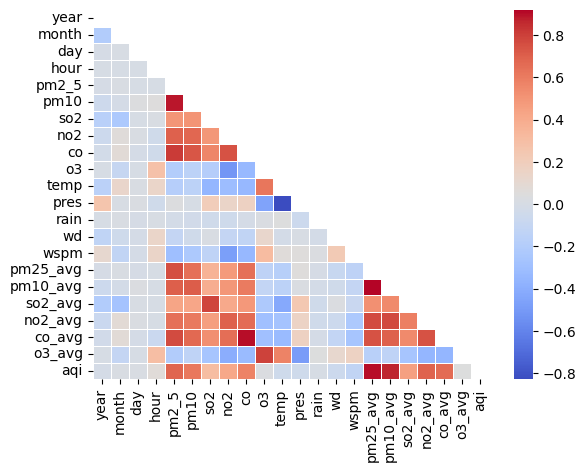

In [34]:
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5, mask = mask)
plt.show()

In [35]:
correlation_matrix['aqi'].sort_values(ascending=False)

aqi         1.000000
pm25_avg    0.904777
pm10_avg    0.868913
no2_avg     0.691547
pm2_5       0.685153
co_avg      0.666119
pm10        0.617665
co          0.573742
so2_avg     0.448075
no2         0.415018
so2         0.305141
hour        0.069121
o3_avg      0.045024
o3          0.029283
day         0.016052
month       0.015797
rain        0.004323
year       -0.013394
pres       -0.047285
temp       -0.049885
wd         -0.062808
wspm       -0.124566
Name: aqi, dtype: float64

We delete rain. AQI obviously shows a high correlation with polluants data. Training a model on this data to predict AQI shows high performances. In order to make it more interesting, we will try to predict AQI from weather data and pm2.5 and o3 concentrations. We delete all the data from other polluants.

In [36]:
del df['rain']
del df['pm2_5']
del df['pm10']
del df['so2']
del df['no2']
del df['co']
del df['o3']
#del df['pm25_avg']
del df['pm10_avg']
del df['so2_avg']
del df['no2_avg']
del df['co_avg']
#del df['o3_avg']
#del df['aqi']

df

,year,month,day,hour,temp,pres,wd,wspm,pm25_avg,o3_avg,aqi
23,2013,3,1,23,1.0,1029.6,67.5,1.8,8.04,50.38,51.38
24,2013,3,2,0,0.5,1030.2,67.5,1.4,7.88,46.25,46.25
25,2013,3,2,1,-0.3,1030.2,90.0,1.0,7.54,42.88,42.88
26,2013,3,2,2,-1.2,1029.6,90.0,0.8,7.33,41.12,41.12
27,2013,3,2,3,-2.9,1029.7,0.0,0.1,7.12,40.25,40.25
...,...,...,...,...,...,...,...,...,...,...,...
35059,2017,2,28,19,12.5,1013.5,315.0,2.4,17.58,80.38,81.38
35060,2017,2,28,20,11.6,1013.6,292.5,0.9,16.12,77.00,78.00
35061,2017,2,28,21,10.8,1014.2,315.0,1.1,14.33,73.50,74.50
35062,2017,2,28,22,10.5,1014.4,337.5,1.2,12.58,70.62,71.62


## AQI Distribution


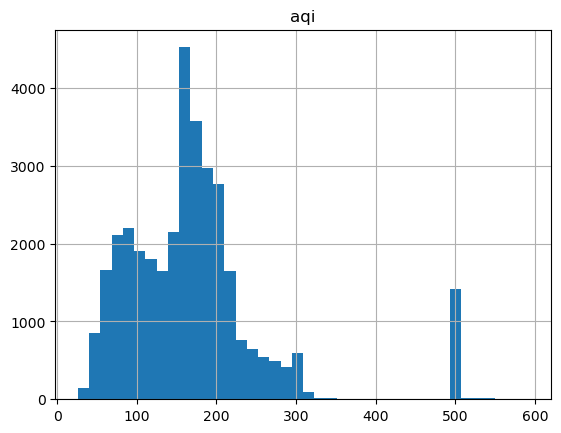

In [37]:
df.hist('aqi', bins=40)
plt.show()

The histogram shows :
- A first peak at aroun 100 and 200, it suggest that most AQI values are within the "Moderate" to "Unhealthy for Sensitive Groups" range.
- There is a large gap between the AQI values under 300 and a significant spike around 500 which represents severe air quality events that are not that common and are "outliers".  

We replace AQI valyes by their class labels :

In [38]:
bins = [0, 50, 100, 150, 200, 300, float('inf')]
labels = ["Good", "Moderate", "Unhealthy for SG", "Unhealthy", "Very Unhealthy", "Hazardous"]
df['aqi_class'] = pd.cut(df['aqi'], bins=bins, labels=labels, right=True)
del df['aqi']
df

,year,month,day,hour,temp,pres,wd,wspm,pm25_avg,o3_avg,aqi_class
23,2013,3,1,23,1.0,1029.6,67.5,1.8,8.04,50.38,Moderate
24,2013,3,2,0,0.5,1030.2,67.5,1.4,7.88,46.25,Good
25,2013,3,2,1,-0.3,1030.2,90.0,1.0,7.54,42.88,Good
26,2013,3,2,2,-1.2,1029.6,90.0,0.8,7.33,41.12,Good
27,2013,3,2,3,-2.9,1029.7,0.0,0.1,7.12,40.25,Good
...,...,...,...,...,...,...,...,...,...,...,...
35059,2017,2,28,19,12.5,1013.5,315.0,2.4,17.58,80.38,Moderate
35060,2017,2,28,20,11.6,1013.6,292.5,0.9,16.12,77.00,Moderate
35061,2017,2,28,21,10.8,1014.2,315.0,1.1,14.33,73.50,Moderate
35062,2017,2,28,22,10.5,1014.4,337.5,1.2,12.58,70.62,Moderate


In [39]:
class_percentages = df['aqi_class'].value_counts(normalize=True) * 100
print(class_percentages)

aqi_class
Unhealthy           36.277503
Moderate            19.668388
Very Unhealthy      19.023430
Unhealthy for SG    17.319711
Hazardous            5.836021
Good                 1.874946
Name: proportion, dtype: float64


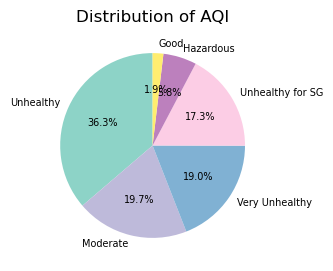

In [40]:
plt.figure(figsize=(10, 3))
group_counts = df['aqi_class'].value_counts()
group_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='Set3',textprops={'fontsize': 7})
plt.title('Distribution of AQI')
plt.ylabel('')  
plt.show()

We see that the distribution of AQI is very imbalanced particularly for the two smallest classes (1.9% and 3.8%). This is quite a challenge as it require careful attention to ensure the model performs well across all classes and does not favor the majority classes.  

We assign a value to each AQI class :

In [41]:
aqi_map = {
    "Good": 0,
    "Moderate": 1,
    "Unhealthy for SG": 2,
    "Unhealthy": 3,
    "Very Unhealthy": 4,
    "Hazardous": 5
}

df['aqi_class'] = df['aqi_class'].cat.rename_categories(aqi_map)

In [42]:
df['aqi_class'].value_counts().sort_values(ascending=False)

aqi_class
3    12712
1     6892
4     6666
2     6069
5     2045
0      657
Name: count, dtype: int64

In [43]:
df.to_csv('AQ_data_cleaned.csv', index=True, sep=',')


## Data splitting
Since we're using time series data, we set shuffle to False in the train_test_split function in order to maitain the continuity of data. In time series data, the order of data points is important.

In [44]:
df_full_train, df_test = train_test_split(df, test_size=0.2, shuffle = False)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, shuffle = False)

In [45]:
len(df_train), len(df_val), len(df_test)

(21024, 7008, 7009)

In [46]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y = df_full_train.aqi_class
y_train = df_train.aqi_class
y_val = df_val.aqi_class
y_test = df_test.aqi_class

del df_full_train['aqi_class']
del df_train['aqi_class']
del df_val['aqi_class']
del df_test['aqi_class']

In [47]:
dico = df_full_train.to_dict(orient='records')
train_dicts = df_train.to_dict(orient='records')
train_val = df_val.to_dict(orient='records')
train_test = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X = dv.fit_transform(dico)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(train_val)
X_test = dv.transform(train_test)

features = dv.get_feature_names_out()
features 

array(['day', 'hour', 'month', 'o3_avg', 'pm25_avg', 'pres', 'temp', 'wd',
       'wspm', 'year'], dtype=object)

## Feature Importance Analysis

Feature Importances:
    Feature  Importance
4  pm25_avg    0.689361
3    o3_avg    0.137790
0       day    0.035685
5      pres    0.034640
6      temp    0.028274
2     month    0.022160
1      hour    0.017902
8      wspm    0.013697
7        wd    0.011275
9      year    0.009217


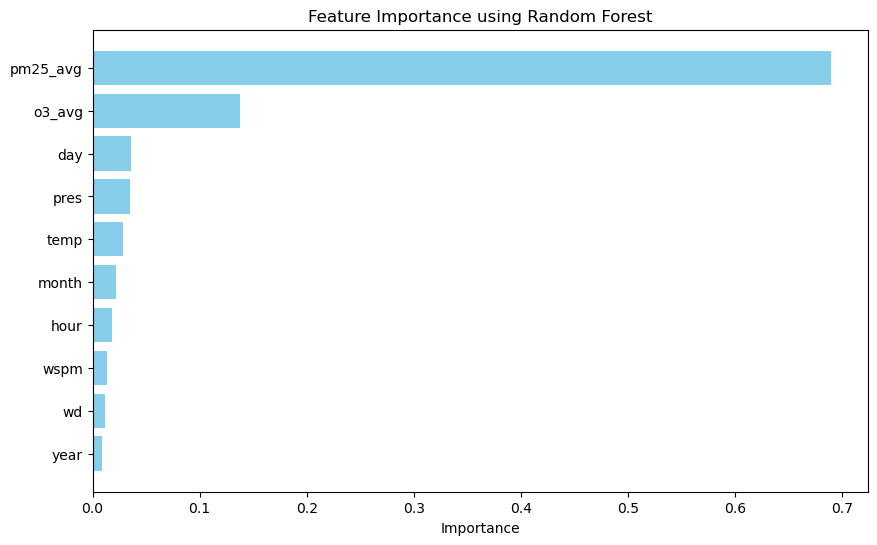

In [48]:
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_
features = dv.get_feature_names_out()  

feature_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

feature_df = feature_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color="skyblue")
plt.xlabel('Importance')
plt.title('Feature Importance using Random Forest')
plt.gca().invert_yaxis()
plt.show()

# Model Training

The goal is to predict the AQI from features above.
- Logistic Regression
- Random Forest


## Logistic Regression

In [49]:
scores = []
lr = LogisticRegression(solver='sag',max_iter=3000, random_state=1)
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred = lr.predict(X_val)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy = accuracy_score(y_val, y_pred)   

scores.append(( accuracy))
print((accuracy, accuracy_train))

(0.8117865296803652, 0.80845700152207)


In [50]:
Acc_list =[]
Reg = [ 0.001, 0.01, 0.1, 1, 10, 100]
for c in Reg :
    
    print(f"For c = {c}")
    
    lr = LogisticRegression(solver='sag', C = c, max_iter=3000, random_state=1)
    lr.fit(X_train, y_train)
    
    y_pred_train = lr.predict(X_train)
    y_pred = lr.predict(X_val)  
    
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy = accuracy_score(y_val, y_pred)    
    
    acc = round(accuracy,3)
    print(f"The accuracy is {acc}, train : {round(accuracy_train,3)}")
    Acc_list.append(accuracy)

    print()

For c = 0.001
The accuracy is 0.809, train : 0.807

For c = 0.01
The accuracy is 0.812, train : 0.809

For c = 0.1
The accuracy is 0.812, train : 0.808

For c = 1
The accuracy is 0.812, train : 0.808

For c = 10
The accuracy is 0.812, train : 0.809

For c = 100
The accuracy is 0.812, train : 0.809



The regularization parameter has little to no effect on the accuracy. The model performs well without needing regularization.


## Random Forest
### Random Forest Tuning
- `n_estimators`
- `max_depth`
- `min_samples_leaf`

In [51]:
scores = []

for n in range(1,10,1):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred_train = rf.predict(X_train)
    y_pred = rf.predict(X_val)
    
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy = accuracy_score(y_val, y_pred)   
    
    scores.append((n, accuracy))
    print('%i -> %.3f, %.3f,' % (n, accuracy, accuracy_train))

1 -> 0.867, 0.980,
2 -> 0.908, 0.979,
3 -> 0.932, 0.995,
4 -> 0.942, 0.994,
5 -> 0.946, 0.998,
6 -> 0.948, 0.997,
7 -> 0.951, 0.999,
8 -> 0.952, 0.998,
9 -> 0.954, 0.999,


The validation accuracy starts at 0.86 and improves to 0.93 with just a small number of trees.  
This suggests that even with a small number of trees, the model captures useful patterns.  
But the model also starts overfitting for a small number of trees. Let's take `n_estimators=3`


In [52]:
depths = [1, 2, 3, 4, 5, 6, 10, 12, 15, 17, 20, 25, 30, 50, 100]
scores = []
for d in depths:
    rf = RandomForestClassifier(n_estimators=3, max_depth=d, random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred_train = rf.predict(X_train)
    y_pred = rf.predict(X_val)
    
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy = accuracy_score(y_val, y_pred)   
    
    scores.append((d, accuracy, accuracy_train))
    print('%i -> %.3f, %.3f,' % (d, accuracy, accuracy_train))

1 -> 0.314, 0.423,
2 -> 0.862, 0.891,
3 -> 0.932, 0.927,
4 -> 0.902, 0.914,
5 -> 0.879, 0.895,
6 -> 0.883, 0.890,
10 -> 0.942, 0.968,
12 -> 0.928, 0.978,
15 -> 0.928, 0.990,
17 -> 0.934, 0.994,
20 -> 0.934, 0.995,
25 -> 0.932, 0.995,
30 -> 0.932, 0.995,
50 -> 0.932, 0.995,
100 -> 0.932, 0.995,


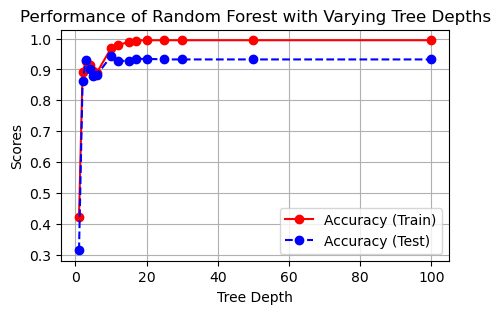

In [53]:
column = ['depth', 'accuracy_val', 'accuracy_train']
score = pd.DataFrame(scores)
score.columns = column

plt.figure(figsize=(5, 3))
plt.plot(score.depth, score.accuracy_train, label="Accuracy (Train)", marker='o', linestyle='-', color='r')
plt.plot(score.depth, score.accuracy_val, label="Accuracy (Test)", marker='o', linestyle='--', color='b')
plt.xlabel('Tree Depth')
plt.ylabel('Scores')
plt.title('Performance of Random Forest with Varying Tree Depths')
plt.legend()
plt.grid(True)
plt.show()

Optimal value of `max_depth = 6`. Choosing depth 6 prioritizes a simpler model with less risk of overfitting in this case. At this depth, the training and validation accuracy are very close, indicating good generalization.









In [54]:
scores = []
for s in range(1,15,1):
    rf = RandomForestClassifier(n_estimators=2, max_depth=6, min_samples_leaf=s, random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred_train = rf.predict(X_train)
    y_pred = rf.predict(X_test)
    
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy = accuracy_score(y_test, y_pred)   
    
    scores.append((s, accuracy, accuracy_train))
    print('%i -> %.4f, %.4f' % (s, accuracy, accuracy_train))

1 -> 0.8993, 0.8791
2 -> 0.8997, 0.8819
3 -> 0.8964, 0.8814
4 -> 0.8967, 0.8765
5 -> 0.8968, 0.8765
6 -> 0.8860, 0.8729
7 -> 0.8849, 0.8746
8 -> 0.8926, 0.8794
9 -> 0.8951, 0.8807
10 -> 0.8953, 0.8807
11 -> 0.8953, 0.8808
12 -> 0.8958, 0.8809
13 -> 0.8957, 0.8809
14 -> 0.8996, 0.8819


 Sticking to default value `min_samples_leaf = 1` is enough.

### Cross-validation
We evaluate the model's performance by splitting the data into 5 folds and training/evaluating the model on different subsets of the whole dataset.  
We have to use TimeSeriesSplit so the data is not shuffled in the splits.

In [55]:

rf = RandomForestClassifier(n_estimators=3, max_depth=6, random_state=1)

tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

for train_index, test_index in tscv.split(X):
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]
    
    rf.fit(X_train_cv, y_train_cv)
    score = rf.score(X_test_cv, y_test_cv)  # or use other metrics
    cv_scores.append(score)

# Print results
print("Cross-validation scores: ", cv_scores)
print("Mean accuracy: ", np.mean(cv_scores))
print("Standard deviation: ", np.std(cv_scores))

Cross-validation scores:  [0.6997003424657534, 0.9034674657534246, 0.8574486301369864, 0.884417808219178, 0.8974743150684932]
Mean accuracy:  0.848501712328767
Standard deviation:  0.07606761574287563


## Final model
After training a logistic regression and a random forest, We select the random forest model as it further improves accuracy.
- `n_estimators` = 3
- `max_depth` = 6 

In [56]:
model_final = RandomForestClassifier(n_estimators = 3, max_depth = 6, random_state=1)
model_final.fit(X_train, y_train)
y_pred = model_final.predict(X_val)